# Tomato Notebook

We want to train a vision learner for tomato pictures that answers the question:
- is my tomato healthy?
- if not: what disease do we see?

Versioning notebook on git:

Import libraries:

In [2]:
import os
from collections import namedtuple
from duckduckgo_search import DDGS
from fastai.vision.all import *
from fastcore.all import *

We are concerned with the following diseases for tomatoes: https://aggie-horticulture.tamu.edu/vegetable/problem-solvers/tomato-problem-solver/leaves/

Export to file for reuse:

In [3]:
%%file ./mappings.py
from collections import namedtuple
sym_ctr = namedtuple('sym_ctr', ['type','symptoms','control'])
tomato_map = {
    'alternaria canker': sym_ctr(
        "disease",
        "Symptoms of Alternaria canker appear on stems, leaves and fruit. Large areas of the leaf lamina between veins is killed, leading to leaf curling and eventual death of the entire leaf.",
        "Fungus overwinters in crop residue and is easily spread by wind. Wounding of young plants (by mechanical damage or pruning) provides an entry site for infection. Furrow or drip irrigation is preferred over sprinkler irrigation. Preventative fungicide sprays may be required if a “zero tolerance” for defects production system is needed."
    ),
    'bacterial canker': sym_ctr(
        "disease",
        "Bacterial canker is characterized by wilting and eventual death of the lower leaves, with the leaves drying up while still attached to the stem. Vascular tissue is discolored, brown, or brownish-yellow, and a characteristic yellow slime can be squeezed from affected stems. The bacterium that causes this disorder may be seed or soil born.",
        "Crop rotations and careful seed source selection are primary considerations. Seed beds in infected areas should be sterilized. Mechanical damage to the transplants (such as topping) spreads the disease."
    ),
    'bacterial speck': sym_ctr(
        "disease",
        "Bacterial speck is widely distributed. Symptoms may appear on any plant part. Leaves of infected plants are covered by small, dark brown, irregular patches of necrotic tissue that are surrounded by yellow halos. Disease severity is increased by leaf wetness from sprinkler irrigation, rain, or heavy dews.",
        "Minimize wetting of the leaves by using drip or furrow irrigation. Copper sprays provide effective control."
    ),
    'bacterial spot': sym_ctr(
        "disease",
        "Dark brown water soaked spots appear on the leaves; later these spots become blackish, and eventually the affected tissue drops out leaving a hole in the leaf. Black, raised specks that later become scab-like spots appear at the same time on fruit.",
        "Crop rotations and careful transplant selection are important. Copper sprays provide some control. Good sanitation practices including prompt plow-down of stubble and weed control help prevent the disease."
    ),
    'early blight': sym_ctr(
        "disease",
        "Leaf symptoms of early blight are large irregular patches of black, necrotic tissue surrounded by larger yellow areas. The leaf spots have a characteristic concentric banding appearance (oyster-shell or bull’s eye).",
        "Minimize wetting of the leaves by using drip or furrow irrigation. Infection occurs rapidly during periods of warm, wet weather. Fungicide sprays control the disease effectively. "
    ),
    'grey leaf spot': sym_ctr(
        "disease",
        "Small brownish-black specks first appear on undersides of leaves. These later develop into larger necrotic areas, and the tissue often falls out, leaving a shot hole type appearance. Spots may be surrounded by a yellow halo. Yellowing, leaf drop, and defoliation may occur in severe cases.",
        "The fungus can survive from year to year on Solanaceous weeds, so weed control is important. Leaf moisture from rains or dew increases disease severity. Fungicides may be used as recommended. Many commercial varieties are resistant."
    ),    
    'late blight': sym_ctr(
        "disease",
        "Lesions on leaves appear as large watersoaked areas, that eventually turn brown and papery. Fruit lesions are large irregular greenish-brown patches having a greasy rough appearance. Green to black irregular lesions are also present on the stems.",
        "The fungus develops during periods of cool wet weather. Fungicide sprays as a preventative measure during these periods may be needed if the crop is being grown near large areas of tomato relatives (Solanaceous weeds, potatoes)."
    ),
    'leaf mold': sym_ctr(
        "disease",
        "Symptoms appear as light green patches on upper surfaces of older leaves. Underneath the leaves in these areas, a purplish or olive-green patch of mold growth is visible. Infected leaves turn yellow and drop off the plant.",
        "Fungus is spread is by wind currents. High humidity and warm temperatures encourage mold growth. The problem is especially severe in greenhouses, where adequate ventilation and air movement reduce disease severity by lowering moisture at the leaf surface. Fungicides are effective controls."
    ),
    'powdery mildew': sym_ctr(
        "disease",
        "Powdery mildew is first noticed on older leaves as a yellow spotted appearance, that upon closer inspection has a whitish-gray powder on the surface. The leaves will eventually die, but usually remain attached to the stem. The disease is worse under warm, dry conditions.",
        "Sulfur dusts or wettable sulfur sprays are effective preventative controls. The established disease will require one of the labelled mildew fungicides."
    ),
    'septoria leaf spot': sym_ctr(
        "disease",
        "Circular water-soaked lesions occur first on older leaves. These spots eventually turn brown with gray centers and die, and if infection is severe enough, the entire leaf will die.",
        "The fungus can survive in the debris from previous crops and/or weeds. Clean cultivation is important. The disease can be controlled by labelled fungicides."
    ),
    'verticillium wilt': sym_ctr(
        "disease",
        "Older leaves on verticillium wilt-infected plants begin wilting at leaf margins and turn yellow, then brown. Plants are stunted and wilting is not alleviated by watering. A light tan discoloration of the stem can be seen in cross section.",
        "The disease develops more rapidly in cool weather. The most effective control is planting one of the widely available resistant varieties."
    ),
    'cucumber mosaic virus': sym_ctr(
        "virus",
        "Virus-infected plants are stunted, often with poorly expanded leaves. Plants are bushy in appearance. Leaves may be mottled, and often have a “shoestring” appearance. Fruit are small and misshaped.",
        "Aphids often are virus vectors, so an attempt to control the aphids is the first step. Eliminate weeds and remove infected plants from the field as soon as they are seen."
    ),
    'spotted wilt': sym_ctr(
        "virus",
        "Fruit are malformed, with raised yellow, red, and green mottled bull’s eye rings. Plants from which fruit are harvested are stunted, with older leaves turning yellow. Leaves show yellow speckling, with dark streaks along the petiole. Growing tips of the leaves may die. The virus is carried by flower and onion thrips that have carried the virus from infected weeds and ornamentals.",
        "Elimination of plants that serve as hosts to thrips is the most important control measure. Clean cultivation, with special attention to border strips is important. Locate production away from large grain fields."
    ),
    'salt damage': sym_ctr(
        "pyhsiological disorders",
        "Excess salt accumulates in the tomato plant in the older leaves. Leaves turn yellow, and will eventually fall off. The plant is stunted and not vigorous, but other symptoms may be lacking. Tomatoes are relatively salt tolerant.",
        "Salt damage is rarely encountered in field situations except under very poor water quality situations. Salt damage may become a problem in pot culture or in hydroponics. Select salt tolerant varieties."
    ),
    'phosphorus deficiency': sym_ctr(
        "physiological disorders",
        "Salt damage is rarely encountered in field situations except under very poor water quality situations. Salt damage may become a problem in pot culture or in hydroponics. Select salt tolerant varieties.",
        "While phosphorus deficiency due to improper fertility may be a problem in hydroponic, pot culture, and some sandy soil conditions, it is most likely a result of cool root zone temperatures. Plastic mulch will alleviate the problem in early field plantings, and a balanced liquid feed fertilizer will alleviate the problem in greenhouse and pot culture."
    ),
    'beet armyworm': sym_ctr(
        "insect damage",
        "Caterpillars have chewing mouthparts. Adults have siphoning mouths. Young larval stages feed close together, often grazing on the outer (epidermal) layer of cells on the underside of leaves. They may spin a light web over the foliage. Older, larger caterpillars feed alone and consume leaf tissue that can result in complete defoliation of host plants.",
        "Consult the Vegetable IPM Web Site for recommended controls of this pest."
    ),
    'leaf miner': sym_ctr(
        "insect damage",
        "Leaf miner larvae tunnel through the lamina of the tomato leaf eating the chlorophyll-rich mesophyll cells as they go. This leaves an irregular track of dead tissue that eventually causes the leaf to stop functioning. High levels of damage on vegetable crops cause stunted growth and reduced yield. High populations of adult flies can injure leaves by producing egg-laying and feeding scars called “stipples.”",
        "Consult the Vegetable IPM Web Site for recommended controls of this pest. Adult leaf miner flies are attracted to yellow cards coated with a sticky layer (yellow sticky cards)."
    )    
}

Writing ./mappings.py


Import and check this file (we need it later on again):

In [4]:
import mappings
print(f"length: {len(mappings.tomato_map)}")
print(f"example: {mappings.tomato_map['alternaria canker']}")

length: 17
example: sym_ctr(type='disease', symptoms='Symptoms of Alternaria canker appear on stems, leaves and fruit. Large areas of the leaf lamina between veins is killed, leading to leaf curling and eventual death of the entire leaf.', control='Fungus overwinters in crop residue and is easily spread by wind. Wounding of young plants (by mechanical damage or pruning) provides an entry site for infection. Furrow or drip irrigation is preferred over sprinkler irrigation. Preventative fungicide sprays may be required if a “zero tolerance” for defects production system is needed.')


Gather images:

In [5]:
#shutil.rmtree("./data")

photo_path = os.path.join(".", "data")
for key in mappings.tomato_map:
    dest = os.path.join(photo_path, key.replace(" ", "_"))
    os.makedirs(dest, exist_ok = True)
    
    with DDGS() as ddgs:
        ddgs_images_gen = ddgs.images(
          keywords=key + " tomato",
          region="wt-wt",
          safesearch="Off",
          size=None,
          type_image=None,
          layout=None,
          license_image=None,
        )
        pic_urls = L(ddgs_images_gen).itemgot("image")
        print(f"processing {key}")
        download_images(dest=dest, urls=pic_urls, max_pics=150)

processing alternaria canker
processing bacterial canker
processing bacterial speck
processing bacterial spot
processing early blight
processing grey leaf spot
processing late blight
processing leaf mold
processing powdery mildew
processing septoria leaf spot
processing verticillium wilt
processing cucumber mosaic virus
processing spotted wilt
processing salt damage
processing phosphorus deficiency
processing beet armyworm
processing leaf miner


Remove images that do not properly load:

In [10]:
failed = verify_images(get_image_files(photo_path))
failed.map(Path.unlink)
print(f"number of incorrect images: {len(failed)}")

/home/stephan/miniconda3/envs/fastai-tomato/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


number of incorrect images: 0


In all classes we end up with similar number of images:

In [11]:
for root, dirs, files in os.walk(photo_path):
    print(f"{root} has {len(files)} files")

./data has 0 files
./data/cucumber_mosaic_virus has 192 files
./data/beet_armyworm has 249 files
./data/spotted_wilt has 199 files
./data/bacterial_spot has 221 files
./data/late_blight has 297 files
./data/bacterial_canker has 255 files
./data/leaf_mold has 255 files
./data/septoria_leaf_spot has 222 files
./data/verticillium_wilt has 224 files
./data/powdery_mildew has 227 files
./data/bacterial_speck has 223 files
./data/phosphorus_deficiency has 135 files
./data/grey_leaf_spot has 202 files
./data/early_blight has 227 files
./data/leaf_miner has 244 files
./data/salt_damage has 187 files
./data/alternaria_canker has 226 files


## Clean up

I cleaned the images by hand - several images where clearly not instances of the correspnding classes. Sample glimps:

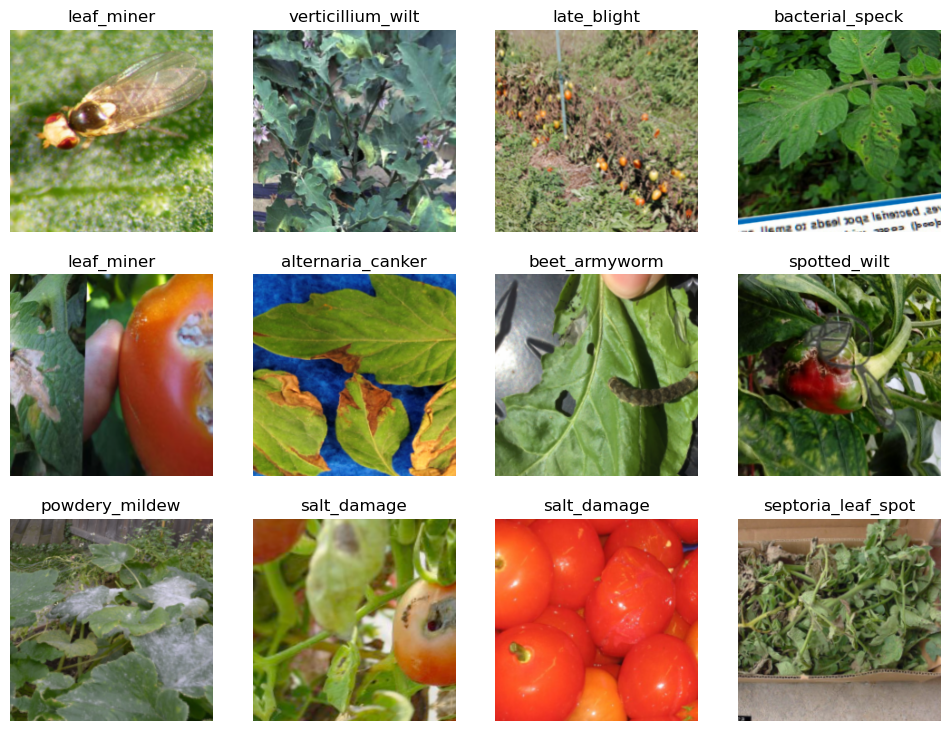

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()    
).dataloaders(photo_path, bs=32)

dls.show_batch(max_n=12)